[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Colunas disponíveis em ensino: ['NO_IES', 'SG_UF_IES', 'TP_CATEGORIA_ADMINISTRATIVA', 'QT_TEC_TOTAL', 'QT_DOC_TOTAL', 'QT_DOC_EX_DOUT', 'QT_DOC_EX_MEST', 'QT_PERIODICO_ELETRONICO', 'QT_LIVRO_ELETRONICO', 'IN_ACESSO_PORTAL_CAPES', 'IN_REPOSITORIO_INSTITUCIONAL', 'IN_SERVICO_INTERNET']
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.71      0.71      0.71         7

    accuracy                           0.60        10
   macro avg       0.52      0.52      0.52        10
weighted avg       0.60      0.60      0.60        10

Acurácia média (validação cruzada): 0.6977777777777778


<ipython-input-6-fbdc61705445>:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['salario_medio'].fillna(dados['salario_medio'].median(), inplace=True)
<ipython-input-6-fbdc61705445>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

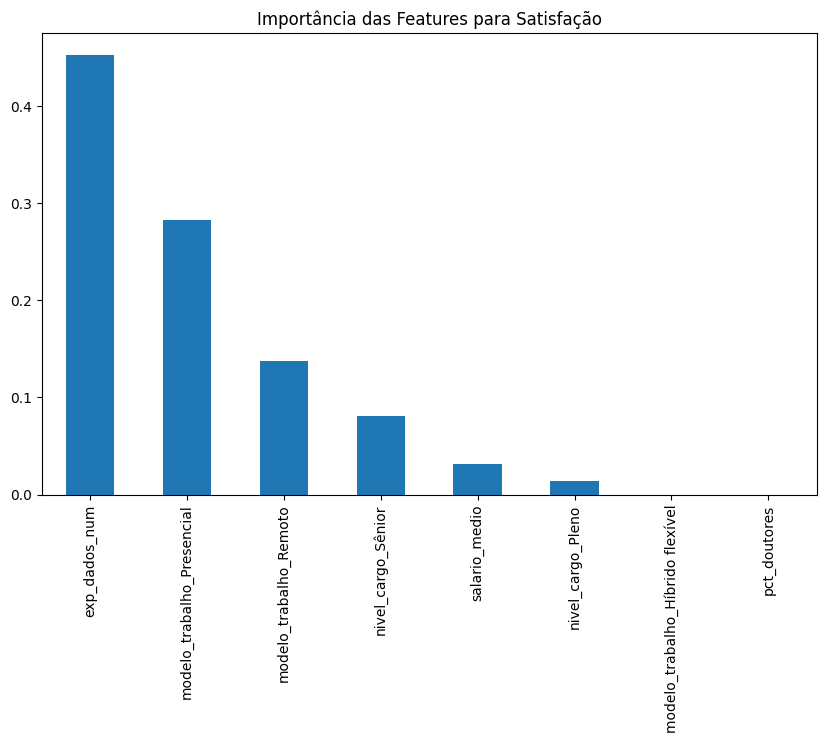

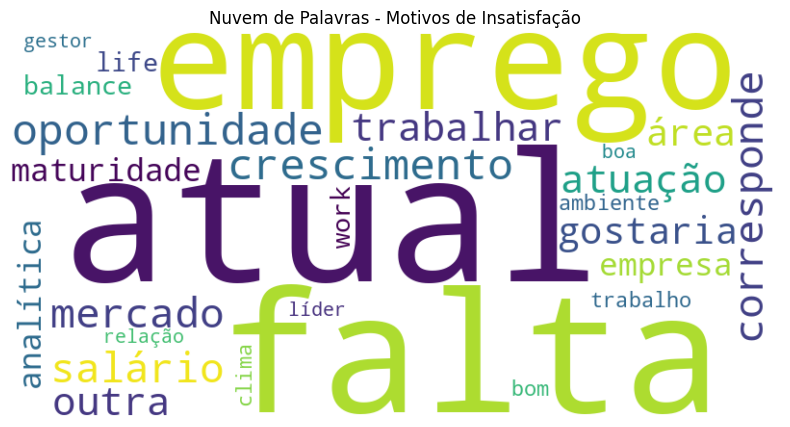

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Baixar recursos do NLTK
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')

# Carregar os dados
dados = pd.read_csv('dados_processados.csv')
ensino = pd.read_excel('Analise_Ensino_Superior_Consolidada.xlsx')

# Verificar colunas do DataFrame ensino
print("Colunas disponíveis em ensino:", ensino.columns.tolist())

# Pré-processamento
# Calcular porcentagem de doutores se '%_Doutores' não existir
if '%_Doutores' not in ensino.columns:
    ensino['pct_doutores'] = (ensino['QT_DOC_EX_DOUT'] / ensino['QT_DOC_TOTAL'] * 100).fillna(0)
else:
    ensino['pct_doutores'] = ensino['%_Doutores']

# Cruzar estado com SG_UF_IES para adicionar pct_doutores
estado_doutores = ensino.groupby('SG_UF_IES')['pct_doutores'].mean().reset_index()
dados = dados.merge(estado_doutores, left_on='estado', right_on='SG_UF_IES', how='left')

# Tratar valores ausentes
dados['salario_medio'].fillna(dados['salario_medio'].median(), inplace=True)
dados['exp_dados_num'].fillna(0, inplace=True)
dados['motivo_insatisfacao'].fillna('', inplace=True)
dados['pct_doutores'].fillna(dados['pct_doutores'].median(), inplace=True)

# Selecionar features
features = ['salario_medio', 'exp_dados_num', 'pct_doutores', 'modelo_trabalho', 'nivel_cargo']
X = dados[features]
y = dados['satisfacao_binaria']

# Codificar variáveis categóricas
X = pd.get_dummies(X, columns=['modelo_trabalho', 'nivel_cargo'], drop_first=True)

# Normalizar variáveis numéricas
scaler = StandardScaler()
X[['salario_medio', 'exp_dados_num', 'pct_doutores']] = scaler.fit_transform(X[['salario_medio', 'exp_dados_num', 'pct_doutores']])

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Treinar árvore de decisão
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=5, criterion='gini', random_state=42)
clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred = clf.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

# Validação cruzada
scores = cross_val_score(clf, X, y, cv=5)
print("Acurácia média (validação cruzada):", scores.mean())

# Importância das features
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importância das Features para Satisfação')
plt.show()

# Análise de texto (motivo_insatisfacao)
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words)
tfidf_matrix = tfidf.fit_transform(dados['motivo_insatisfacao'])
terms = tfidf.get_feature_names_out()
word_scores = tfidf_matrix.sum(axis=0).A1
word_importance = pd.Series(word_scores, index=terms).sort_values(ascending=False)

# Nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_importance)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Motivos de Insatisfação')
plt.savefig('wordcloud_insatisfacao.png')